In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/gdrive/My\ Drive/project_DL/deepfool.py /content
!cp /content/gdrive/My\ Drive/project_DL/test_im1.jpg /content
!cp /content/gdrive/My\ Drive/project_DL/test_im2.jpg /content
!cp /content/gdrive/My\ Drive/project_DL/synset_words.txt /content

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import math
import torchvision.models as models
from PIL import Image
from deepfool import deepfool
import os


In [8]:
net = models.resnet34(pretrained=True)

# Switch to evaluation mode
net.eval()


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 172770062.44it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


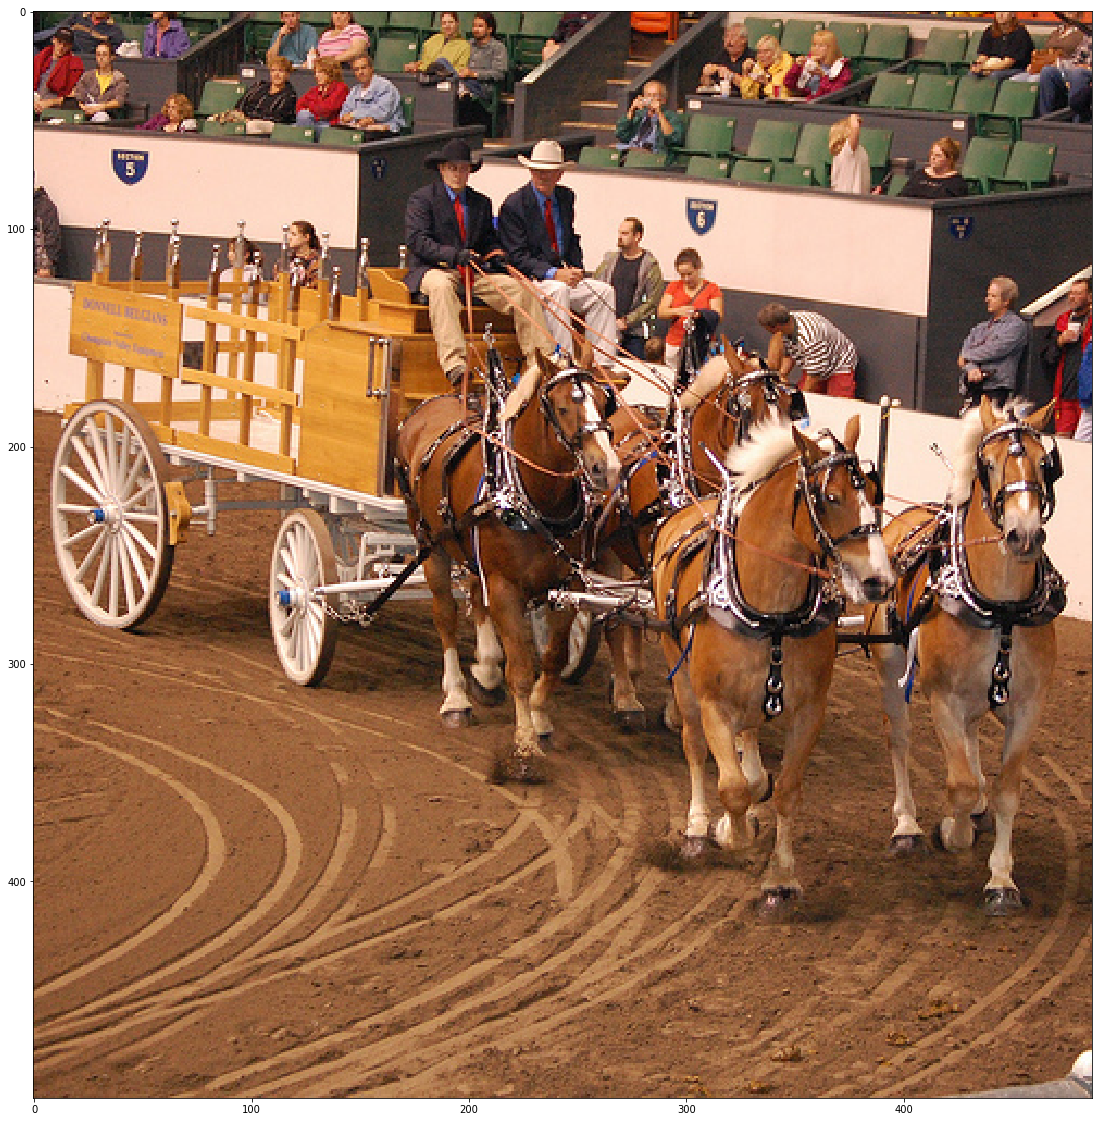

In [24]:
im_orig = Image.open('test_im2.jpg')

mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]


# Remove the mean
im = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean,
                         std = std)])(im_orig)
plt.figure(figsize=(20,20))
plt.imshow(im_orig)

In [14]:
r, loop_i, label_orig, label_pert, pert_image = deepfool(im, net)

labels = open(os.path.join('synset_words.txt'), 'r').read().split('\n')

str_label_orig = labels[np.int(label_orig)].split(',')[0]
str_label_pert = labels[np.int(label_pert)].split(',')[0]

print("Original label = ", str_label_orig)
print("Perturbed label = ", str_label_pert)


Using GPU
Original label =  n03538406 horse cart
Perturbed label =  n02437312 Arabian camel


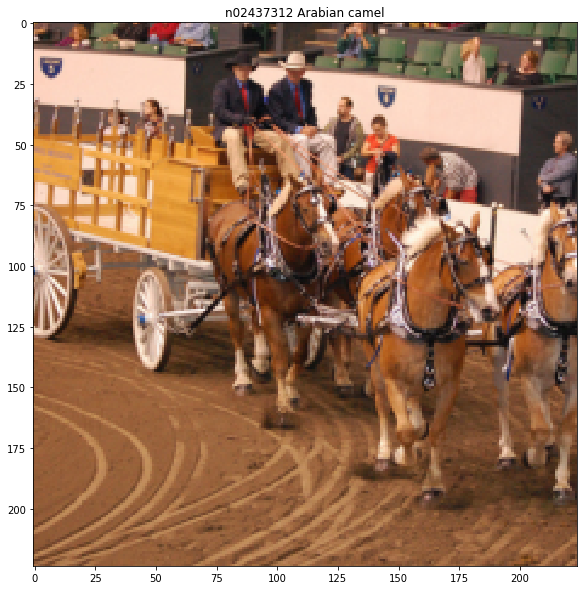

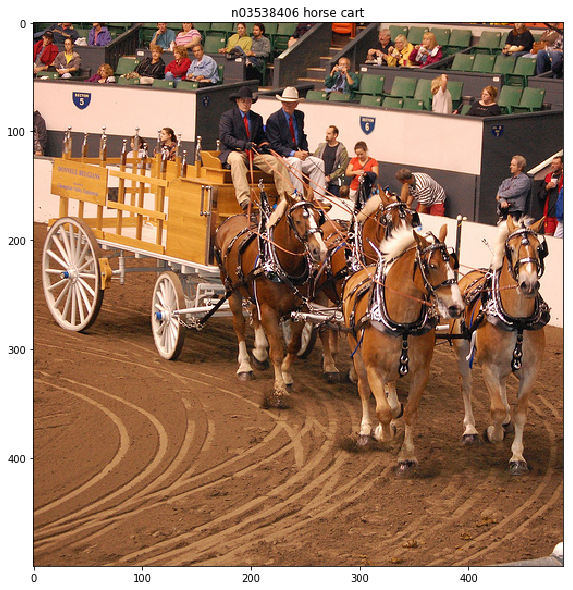

In [36]:
def clip_tensor(A, minv, maxv):
    A = torch.max(A, minv*torch.ones(A.shape))
    A = torch.min(A, maxv*torch.ones(A.shape))
    return A

clip = lambda x: clip_tensor(x, 0, 255)

#print(list(map(lambda x: 1 / x, std)))

tf = transforms.Compose([transforms.Normalize(mean=[0,0,0], std=list(map(lambda x: 1 / x, std))),
                        transforms.Normalize(mean=list(map(lambda x: -x, mean)), std=[1, 1, 1]),
                        transforms.Lambda(clip),
                        transforms.ToPILImage(),
                        transforms.CenterCrop(224)])
plt.figure(figsize=(10,10))
plt.imshow(tf(pert_image.cpu()[0]))

plt.title(str_label_pert)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(im_orig)

plt.title(str_label_orig)
plt.show()

